In [3]:
import os, sys, shutil
import torch
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib as plt
from PIL import Image
sys.path.append("../src")
from utils import *
from autoencoder import AutoEncoder
from gnet8_encoder import GNet8_Encoder
from matplotlib.lines import Line2D
import matplotlib as mpl
import math
import matplotlib.image as mpimg
import random
os.chdir("..")

/export/raid1/home/kneel027/miniconda3/envs/SS/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
_, _, x_test, _, _, images, _ = load_nsd(vector="images", subject=1, loader=False, average=False, nest=True, return_sessions=False, include_heldout=True)
# x_test, images = load_nsd_mental_imagery(vector = "images", subject=1, mode="imagery", stimtype="complex", average=False, nest=True, epoch=0)

torch.Size([30000, 15724])


loading samples: 100%|██████████| 30000/30000 [00:16<00:00, 1853.25it/s] 


Data Shapes... x_train: torch.Size([22950, 15724]), x_val: torch.Size([4050, 15724]), x_test: torch.Size([1000, 3, 15724]), y_train: torch.Size([22950, 541875]), y_val: torch.Size([4050, 541875]), y_test: torch.Size([1000, 541875])


In [5]:
# betas are of dimension (num_images, num_trials, num_voxels)
def calculate_snr_preaverage(betas):
    averaged_betas = torch.mean(betas, dim=1)
    print(averaged_betas.shape)
    signal = torch.var(averaged_betas, dim=0)
    trial_variance = torch.var(betas, dim=1)
    print(trial_variance.shape)
    noise = torch.mean(trial_variance, dim=0)
    snr = torch.mean(signal / noise)
    print("signal: ", signal.shape, signal)
    print("noise: ", noise.shape, noise)
    return snr, torch.mean(signal), torch.mean(noise)
    
def calculate_snr(betas):
    signal = torch.var(torch.mean(betas, dim=1))
    noise = torch.mean(torch.var(betas, dim=1))
    snr = signal / noise
    return snr, signal, noise
mask = torch.load("/home/naxos2-raid25/kneel027/home/kneel027/Second-Sight/data/preprocessed_data/subject1/masks/early_vis.pt")
x_test = x_test[:, :, mask]
snr, signal, noise = calculate_snr(x_test)
print(f"Shared1000 Betas, SNR: {snr}, Signal: {signal}, Noise: {noise}")

Shared1000 Betas, SNR: 0.5724920630455017, Signal: 0.43212106823921204, Noise: 0.7548071146011353


In [36]:

snrs, signals, noises = [], [], []
for iteration in range(10):
    beta_primes = []
    for image in range(1000):
        if os.path.exists(f"/home/naxos2-raid25/kneel027/home/kneel027/Second-Sight/output/mindeye_extension_v6/subject1/{image}/iter_{iteration}/best_batch/beta_primes/"):
            beta_prime = torch.zeros(5, x_test.shape[2])
            for trial in range(5):
                beta_prime[trial] = torch.load(f"/home/naxos2-raid25/kneel027/home/kneel027/Second-Sight/output/mindeye_extension_v6/subject1/{image}/iter_{iteration}/best_batch/beta_primes/{trial}.pt")
            beta_primes.append(beta_prime)
    beta_primes = torch.stack(beta_primes)
    # dims = beta_primes.shape
    # beta_primes = beta_primes.reshape(dims[0] * dims[1], dims[2])
    # indices = torch.randperm(beta_primes.size(0))
    # beta_primes = beta_primes[indices]
    # beta_primes = beta_primes.reshape(dims[0], dims[1], dims[2])
    # print("BETA PRIME STATS", beta_primes.shape, torch.mean(beta_primes), torch.var(beta_primes), torch.std(beta_primes))
    snr, signal, noise = calculate_snr(beta_primes)
    snrs.append(snr)
    signals.append(signal)
    noises.append(noise)
    print(f"Iteration {iteration}, SNR: {snr}, Signal: {signal}, Noise: {noise}")

Iteration 0, SNR: 5.519580364227295, Signal: 0.1259210854768753, Noise: 0.022813525050878525
Iteration 1, SNR: 10.65185260772705, Signal: 0.13108642399311066, Noise: 0.01230644341558218
Iteration 2, SNR: 15.335140228271484, Signal: 0.1322668492794037, Noise: 0.008625082671642303
Iteration 3, SNR: 19.320838928222656, Signal: 0.13137006759643555, Noise: 0.006799397524446249
Iteration 4, SNR: 26.068532943725586, Signal: 0.12962494790554047, Noise: 0.004972468130290508
Iteration 5, SNR: 30.2148494720459, Signal: 0.12339673936367035, Noise: 0.004083976615220308
Iteration 6, SNR: 37.837196350097656, Signal: 0.11781266331672668, Noise: 0.0031136733014136553
Iteration 7, SNR: 47.5826416015625, Signal: 0.11170484125614166, Noise: 0.0023475964553654194
Iteration 8, SNR: 61.4997673034668, Signal: 0.10785052925348282, Noise: 0.001753673772327602
Iteration 9, SNR: 99.45069885253906, Signal: 0.10465738922357559, Noise: 0.0010523544624447823


In [40]:
snrs, signals, noises = [], [], []
output_path = "/home/naxos2-raid25/kneel027/home/kneel027/Second-Sight/output/snr_threshold_v1"

for strength in tqdm([1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]):
    beta_primes = torch.zeros((100, 3, 15724))
    for sample in range(100):
        beta_primes[sample] = torch.load(f"{output_path}/subject1/{strength}/{sample}/beta_primes.pt")
        # print(beta_primes[sample].shape)
    print("BETA PRIME STATS", beta_primes.shape, torch.mean(beta_primes), torch.var(beta_primes), torch.std(beta_primes))
    snr, signal, noise = calculate_snr(beta_primes)
    snrs.append(snr)
    signals.append(signal)
    noises.append(noise)
    print(f"Iteration {strength}, SNR: {snr}, Signal: {signal}, Noise: {noise}")

 10%|█         | 1/10 [00:00<00:01,  5.21it/s]

BETA PRIME STATS torch.Size([100, 3, 15724]) tensor(-0.2046) tensor(0.2200) tensor(0.4690)
Iteration 1.0, SNR: 21.42152976989746, Signal: 0.2133316993713379, Noise: 0.009958751499652863
BETA PRIME STATS torch.Size([100, 3, 15724]) tensor(-0.2110) tensor(0.2211) tensor(0.4702)


 30%|███       | 3/10 [00:00<00:01,  5.61it/s]

Iteration 0.9, SNR: 22.48235321044922, Signal: 0.21470865607261658, Noise: 0.009550097398459911
BETA PRIME STATS torch.Size([100, 3, 15724]) tensor(-0.2131) tensor(0.2201) tensor(0.4691)
Iteration 0.8, SNR: 25.687646865844727, Signal: 0.21450085937976837, Noise: 0.008350350894033909
BETA PRIME STATS torch.Size([100, 3, 15724]) 

 40%|████      | 4/10 [00:00<00:01,  5.58it/s]

tensor(-0.2160) tensor(0.2205) tensor(0.4696)
Iteration 0.7, SNR: 28.547988891601562, Signal: 0.21549074351787567, Noise: 0.007548368535935879
BETA PRIME STATS torch.Size([100, 3, 15724]) tensor(-0.2197) tensor(0.2181) tensor(0.4670)


 60%|██████    | 6/10 [00:01<00:00,  5.63it/s]

Iteration 0.6, SNR: 33.59797286987305, Signal: 0.21380816400051117, Noise: 0.006363722030073404
BETA PRIME STATS torch.Size([100, 3, 15724]) tensor(-0.2245) tensor(0.2142) tensor(0.4628)
Iteration 0.5, SNR: 33.19110107421875, Signal: 0.20998640358448029, Noise: 0.006326587405055761


 70%|███████   | 7/10 [00:01<00:00,  5.60it/s]

BETA PRIME STATS torch.Size([100, 3, 15724]) tensor(-0.2330) tensor(0.2080) tensor(0.4561)
Iteration 0.4, SNR: 38.325626373291016, Signal: 0.20447547733783722, Noise: 0.005335215479135513
BETA PRIME STATS torch.Size([100, 3, 15724]) tensor(-0.2449) tensor(0.2037) tensor(0.4514)


 90%|█████████ | 9/10 [00:01<00:00,  5.60it/s]

Iteration 0.3, SNR: 52.7389030456543, Signal: 0.2011791169643402, Noise: 0.00381462462246418
BETA PRIME STATS torch.Size([100, 3, 15724]) tensor(-0.2620) tensor(0.2053) tensor(0.4531)
Iteration 0.2, SNR: 139.8489990234375, Signal: 0.20430885255336761, Noise: 0.0014609246281906962


100%|██████████| 10/10 [00:01<00:00,  5.61it/s]

BETA PRIME STATS torch.Size([100, 3, 15724]) tensor(-0.2742) tensor(0.2103) tensor(0.4586)
Iteration 0.1, SNR: 516.6364135742188, Signal: 0.21000616252422333, Noise: 0.0004064873210154474


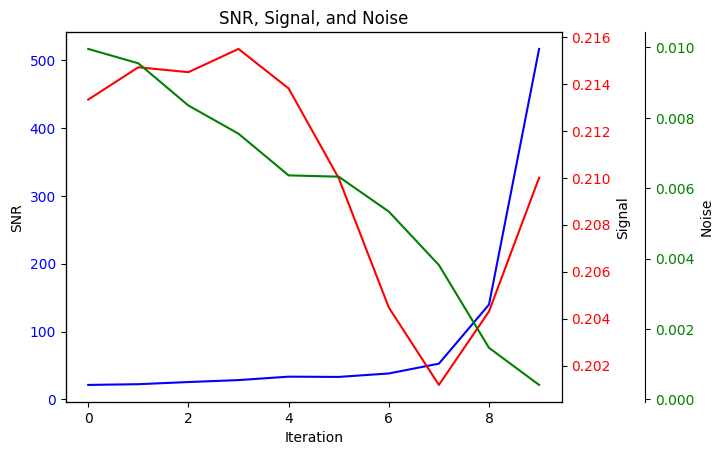

In [39]:
import matplotlib.pyplot as plt

# Create figure and axes
fig, ax1 = plt.subplots()

# Plot SNR
ax1.plot(snrs, label='SNR', color='blue')
ax1.set_ylabel('SNR')
ax1.set_xlabel('Iteration')
ax1.tick_params(axis='y', labelcolor='blue')

# Create second y-axis
ax2 = ax1.twinx()

# Plot Signal
ax2.plot(signals, label='Signal', color='red')
ax2.set_ylabel('Signal')
ax2.tick_params(axis='y', labelcolor='red')

# Create third y-axis
ax3 = ax1.twinx()

# Plot Noise
ax3.plot(noises, label='Noise', color='green')
ax3.set_ylabel('Noise')
ax3.spines['right'].set_position(('outward', 60))
ax3.tick_params(axis='y', labelcolor='green')

# Adding labels and title
plt.xlabel('Iteration')
plt.title('SNR, Signal, and Noise')

# Display the plot
plt.show()


In [ ]:
import os
import torch

for iteration in range(10):
    beta_primes = []
    for image in tqdm(range(1000)):
        if os.path.exists(f"/home/naxos2-raid25/kneel027/home/kneel027/Second-Sight/output/mindeye_extension_v6/subject1/{image}/iter_{iteration}/best_batch/beta_primes/"):
            beta_primes_sample = []
            directory = f"/home/naxos2-raid25/kneel027/home/kneel027/Second-Sight/output/mindeye_extension_v6/subject1/{image}/iter_{iteration}/best_batch/beta_primes/"
            for filename in os.listdir(directory):
                if filename.endswith(".pt"):
                    file_path = os.path.join(directory, filename)
                    beta_prime = torch.load(file_path)
                    beta_primes_sample.append(beta_prime)

            beta_prime = torch.stack(beta_primes_sample)
            beta_prime = torch.mean(beta_prime, dim=0)
            beta_primes.append(beta_prime)
    beta_primes = torch.stack(beta_primes)
    print(iteration, torch.var(beta_primes))
    # dims = beta_primes.shape
    # beta_primes = beta_primes.reshape(dims[0] * dims[1], dims[2])
    # indices = torch.randperm(beta_primes.size(0))
    # beta_primes = beta_primes[indices]
    # beta_primes = beta_primes.reshape(dims[0], dims[1], dims[2])
    # print(beta_primes.shape)
    # snr, signal, noise = calculate_snr(beta_primes)
    # snrs.append(snr)
    # signals.append(signal)
    # noises.append(noise)
    # print(iteration, snr)

100%|██████████| 1000/1000 [05:44<00:00,  2.90it/s]


0 tensor(0.1217)


100%|██████████| 1000/1000 [01:14<00:00, 13.47it/s]


1 tensor(0.1296)


100%|██████████| 1000/1000 [01:12<00:00, 13.86it/s]


2 tensor(0.1315)


100%|██████████| 1000/1000 [01:03<00:00, 15.77it/s]


3 tensor(0.1307)


100%|██████████| 1000/1000 [00:52<00:00, 19.19it/s]


4 tensor(0.1293)


100%|██████████| 1000/1000 [00:40<00:00, 24.94it/s]


5 tensor(0.1232)


100%|██████████| 1000/1000 [00:27<00:00, 36.57it/s]


6 tensor(0.1178)


100%|██████████| 1000/1000 [00:14<00:00, 68.72it/s]


7 tensor(0.1117)


100%|██████████| 1000/1000 [00:06<00:00, 150.27it/s]


8 tensor(0.1079)


100%|██████████| 1000/1000 [00:05<00:00, 198.78it/s]

9 tensor(0.1047)
